In [1]:
import datetime as dt
from multiprocessing import Pool

from IPython.display import Latex

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

from numba import njit, prange, float64, vectorize
import numpy as np

from wf import sigma, epsilon, eta, V_lj, build_fn

from scipy.linalg import eig
from scipy.optimize import curve_fit
from scipy.special import gamma

from matplotlib.backends.backend_pdf import PdfPages

np.random.seed(0)

## Parameters of the system

In [2]:
N = 125

rho0 = 21.8e-3 * sigma**3
L = (N / (rho0))**(1/3)

fn, rgrid = build_fn(L, 10)

Latex(f'$L = {L:.3f}\\ \\sigma$')

<IPython.core.display.Latex object>

In [3]:
from itertools import product

# intial configuration
conf = np.zeros((N, 3))
per_side = round(N**(1/3))

ind = 0 # uniformly distributed particles
for i, j, k in product(range(per_side), repeat=3):
    conf[ind] = L / per_side * np.array([i, j, k])
    ind += 1

# Variational wave function

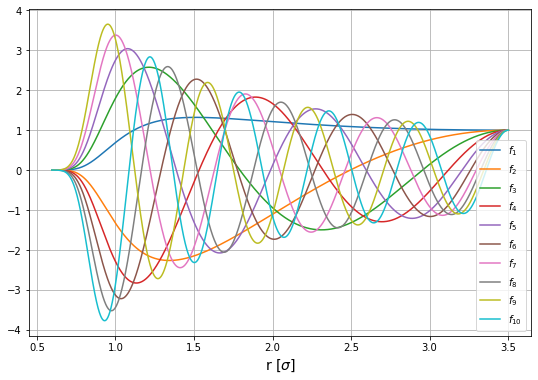

In [4]:
# create function for every fn and derivatives
fn_prime  = np.apply_along_axis(np.gradient, 1, fn, rgrid)
fn_prime[:, -2] = 0

fn_second = np.apply_along_axis(np.gradient, 1, fn_prime, rgrid)

f0 = njit(lambda r: np.interp(r, rgrid, fn[0]), fastmath=True)
f0_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[0]), fastmath=True)
f0_second = njit(lambda r: np.interp(r, rgrid, fn_second[0]), fastmath=True)

f1 = njit(lambda r: np.interp(r, rgrid, fn[1]), fastmath=True)
f1_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[1]), fastmath=True)
f1_second = njit(lambda r: np.interp(r, rgrid, fn_second[1]), fastmath=True)

f2 = njit(lambda r: np.interp(r, rgrid, fn[2]), fastmath=True)
f2_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[2]), fastmath=True)
f2_second = njit(lambda r: np.interp(r, rgrid, fn_second[2]), fastmath=True)

f3 = njit(lambda r: np.interp(r, rgrid, fn[3]), fastmath=True)
f3_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[3]), fastmath=True)
f3_second = njit(lambda r: np.interp(r, rgrid, fn_second[3]), fastmath=True)

f4 = njit(lambda r: np.interp(r, rgrid, fn[4]), fastmath=True)
f4_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[4]), fastmath=True)
f4_second = njit(lambda r: np.interp(r, rgrid, fn_second[4]), fastmath=True)

f5 = njit(lambda r: np.interp(r, rgrid, fn[5]), fastmath=True)
f5_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[5]), fastmath=True)
f5_second = njit(lambda r: np.interp(r, rgrid, fn_second[5]), fastmath=True)

f6 = njit(lambda r: np.interp(r, rgrid, fn[6]), fastmath=True)
f6_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[6]), fastmath=True)
f6_second = njit(lambda r: np.interp(r, rgrid, fn_second[6]), fastmath=True)

f7 = njit(lambda r: np.interp(r, rgrid, fn[7]), fastmath=True)
f7_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[7]), fastmath=True)
f7_second = njit(lambda r: np.interp(r, rgrid, fn_second[7]), fastmath=True)

f8 = njit(lambda r: np.interp(r, rgrid, fn[8]), fastmath=True)
f8_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[8]), fastmath=True)
f8_second = njit(lambda r: np.interp(r, rgrid, fn_second[8]), fastmath=True)

f9 = njit(lambda r: np.interp(r, rgrid, fn[9]), fastmath=True)
f9_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[9]), fastmath=True)
f9_second = njit(lambda r: np.interp(r, rgrid, fn_second[9]), fastmath=True)

pdf = PdfPages('fn.pdf')
for i in range(10):
    plt.plot(rgrid, eval(f'f{i}(rgrid)'), label=f'$f_{{{i+1}}}$')

plt.xlabel('r [$\\sigma$]', fontsize=14)
plt.legend()
plt.grid()

pdf.savefig()
pdf.close()

[ 0.88606537  0.13041384 -0.02524013  0.01070462 -0.00555625  0.00363506
 -0.00237936  0.00185466 -0.00124965  0.00175186]


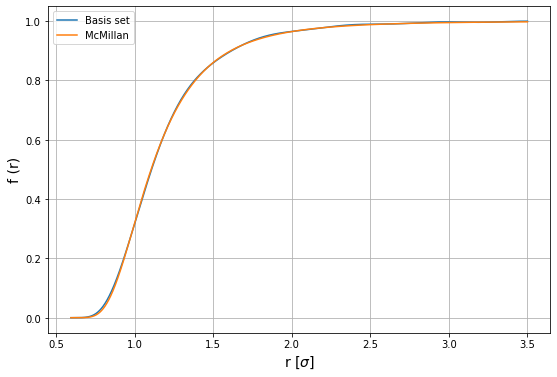

In [5]:
# starting values of cn: fit f on McMillan function
def f_fit(r, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9):
    value  = c0*f0(r) + c1*f1(r) + c2*f2(r) + c3*f3(r) + c4*f4(r)
    value += c5*f5(r) + c6*f6(r) + c7*f7(r) + c8*f8(r) + c9*f9(r)
    return value

McMillan = np.exp(- 0.5 * (1.18**5 / rgrid**5))
cn, pcov = curve_fit(f_fit, rgrid, McMillan)

cn = cn / np.sum(cn)

print(cn)

plt.plot(rgrid, f_fit(rgrid, *cn),  label='Basis set')
plt.plot(rgrid, np.exp(- 0.5 * (1.18**5 / rgrid**5)), label='McMillan')
plt.xlabel('r [$\\sigma$]', fontsize=14)
plt.ylabel('f (r)', fontsize=14)
plt.legend()
plt.grid()

In [6]:
@njit(fastmath=True)
def psi(conf, f, L):
    # pairwise vector distance matrix
    R_ij = conf - np.expand_dims(conf, axis=1)
    R_ij = R_ij - L * np.rint(R_ij / L)

    # pairwise distance matrix
    r_ij = np.sqrt(np.sum(R_ij**2, axis=2))
    
    r_ij = np.where((r_ij > 0) & (r_ij < L/2), r_ij, L/2)

    return np.sqrt(np.prod(f(r_ij)))

In [7]:
@njit(fastmath=True) # sample MC configurations on psi(*, f)
def sample(conf, f, L, n_samples):
    # number of particles
    N = conf.shape[0]
    # equilibration steps
    eq_steps = 15000
    
    # delta parameter starting value
    delta = L / 10
    
    # forward steps in Markov chain
    fw_steps = 0

    # EQUILIBRATION: bring system to equilibrium
    P_i = psi(conf, f, L)**2
    for i in range(eq_steps):    
        # sample random particles to move
        to_move = np.random.choice(N, size=N//4, replace=False)
        
        # build proposal for the step
        proposal = np.copy(conf)
        proposal[to_move] += delta * (np.random.rand(N//4, 3) - 0.5)
        proposal = proposal - L * np.floor(proposal / L) # pbc
        
        # probability of proposal configuration
        P_p = psi(proposal, f, L)**2
        # Markov chain step decision
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
            fw_steps += 1

        # update delta value every 500 steps based on % of forward steps
        if ((i+1) % 500 == 0):
            if (fw_steps > 0.29 * 500) or (fw_steps < 0.33 * 500):
                delta = delta * (1 + fw_steps/500 - 0.31)
            # reset forward steps counter
            fw_steps = 0
    
    samples = np.zeros((n_samples, N, 3))
    
    # SAMPLING
    P_i = psi(conf, f, L)**2
    for i in range(n_samples * 20):
        # sample random particles to move
        to_move = np.random.choice(N, size=N//4, replace=False)

        # build proposal for the step
        proposal = np.copy(conf)
        proposal[to_move] += delta * (np.random.rand(N//4, 3) - 0.5)
        proposal = proposal - L * np.floor(proposal / L) # pbc
        
        # probability of proposal configuration
        P_p = psi(proposal, f, L)**2
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)

        samples[i // 20] = np.copy(conf)

    return samples

In [8]:
@njit(fastmath=True)
def energy(samples, f, f_prime, f_second, L):
    # number of particles
    N = samples.shape[1]
    # number of uncorrelated samples
    n_samples = samples.shape[0]
    
    # local energy
    E_l = np.zeros(n_samples)
    # E_lj
    E_lj = np.zeros((10, n_samples))
    # psi_j / psi_0
    psi_j0 = np.zeros((10, n_samples))

    for i in range(n_samples):
        # pairwise vetor distance matrix
        R_kl = samples[i] - np.expand_dims(samples[i], axis=1)
        R_kl = R_kl - L * np.rint(R_kl / L)

        # pairwise distance matrix
        r_kl = np.sqrt(np.sum(R_kl**2, axis=2))
        # avoid r_ii and cutoff at L/2
        r_kl = np.where((r_kl < L/2) & (r_kl > 0), r_kl, L/2)
        
        f_kl = f(r_kl)

        u0 = - f0(r_kl) / f_kl
        u1 = - f1(r_kl) / f_kl
        u2 = - f2(r_kl) / f_kl
        u3 = - f3(r_kl) / f_kl
        u4 = - f4(r_kl) / f_kl
        u5 = - f5(r_kl) / f_kl
        u6 = - f6(r_kl) / f_kl
        u7 = - f7(r_kl) / f_kl
        u8 = - f8(r_kl) / f_kl
        u9 = - f9(r_kl) / f_kl
        
        u_prime  = - f_prime(r_kl) / f_kl
        
        u0_prime = - f0_prime(r_kl) / f_kl + u_prime * u0
        u1_prime = - f1_prime(r_kl) / f_kl + u_prime * u1
        u2_prime = - f2_prime(r_kl) / f_kl + u_prime * u2
        u3_prime = - f3_prime(r_kl) / f_kl + u_prime * u3
        u4_prime = - f4_prime(r_kl) / f_kl + u_prime * u4
        u5_prime = - f5_prime(r_kl) / f_kl + u_prime * u5
        u6_prime = - f6_prime(r_kl) / f_kl + u_prime * u6
        u7_prime = - f7_prime(r_kl) / f_kl + u_prime * u7
        u8_prime = - f8_prime(r_kl) / f_kl + u_prime * u8
        u9_prime = - f9_prime(r_kl) / f_kl + u_prime * u9
        
        u_second = u_prime**2 - f_second(r_kl) / f_kl
        
        u0_second  = - f0_second(r_kl) / f_kl + u0 * (u_second - u_prime**2)
        u0_second += 2 * u_prime * u0_prime
        
        u1_second  = - f1_second(r_kl) / f_kl + u1 * (u_second - u_prime**2)
        u1_second += 2 * u_prime * u1_prime
        
        u2_second  = - f2_second(r_kl) / f_kl + u2 * (u_second - u_prime**2)
        u2_second += 2 * u_prime * u2_prime
        
        u3_second  = - f3_second(r_kl) / f_kl + u3 * (u_second - u_prime**2)
        u3_second += 2 * u_prime * u3_prime
        
        u4_second  = - f4_second(r_kl) / f_kl + u4 * (u_second - u_prime**2)
        u4_second += 2 * u_prime * u4_prime
        
        u5_second  = - f5_second(r_kl) / f_kl + u5 * (u_second - u_prime**2)
        u5_second += 2 * u_prime * u5_prime
        
        u6_second  = - f6_second(r_kl) / f_kl + u6 * (u_second - u_prime**2)
        u6_second += 2 * u_prime * u6_prime
        
        u7_second  = - f7_second(r_kl) / f_kl + u7 * (u_second - u_prime**2)
        u7_second += 2 * u_prime * u7_prime

        u8_second  = - f8_second(r_kl) / f_kl + u8 * (u_second - u_prime**2)
        u8_second += 2 * u_prime * u8_prime
        
        u9_second  = - f9_second(r_kl) / f_kl + u9 * (u_second - u_prime**2)
        u9_second += 2 * u_prime * u9_prime
        
        grad  = np.sum(u_prime  / r_kl * R_kl.T, axis=1)
        grad0 = np.sum(u0_prime / r_kl * R_kl.T, axis=1)
        grad1 = np.sum(u1_prime / r_kl * R_kl.T, axis=1)
        grad2 = np.sum(u2_prime / r_kl * R_kl.T, axis=1)
        grad3 = np.sum(u3_prime / r_kl * R_kl.T, axis=1)
        grad4 = np.sum(u4_prime / r_kl * R_kl.T, axis=1)
        grad5 = np.sum(u5_prime / r_kl * R_kl.T, axis=1)
        grad6 = np.sum(u6_prime / r_kl * R_kl.T, axis=1)
        grad7 = np.sum(u7_prime / r_kl * R_kl.T, axis=1)
        grad8 = np.sum(u8_prime / r_kl * R_kl.T, axis=1)
        grad9 = np.sum(u9_prime / r_kl * R_kl.T, axis=1)
        
        psi_j0[0, i] = np.sum(- u0) / 2
        psi_j0[1, i] = np.sum(- u1) / 2
        psi_j0[2, i] = np.sum(- u2) / 2
        psi_j0[3, i] = np.sum(- u3) / 2
        psi_j0[4, i] = np.sum(- u4) / 2
        psi_j0[5, i] = np.sum(- u5) / 2
        psi_j0[6, i] = np.sum(- u6) / 2
        psi_j0[7, i] = np.sum(- u7) / 2
        psi_j0[8, i] = np.sum(- u8) / 2
        psi_j0[9, i] = np.sum(- u9) / 2
        
        psi_j0[:, i] -= len(np.where(r_kl == L/2)[0]) / 2
        
        E_lj[0, i] = np.sum(u0_second + 2/r_kl * u0_prime) # Laplacian
        E_lj[0, i] -= 2 * np.sum(grad * grad0)
        
        E_lj[1, i] = np.sum(u1_second + 2/r_kl * u1_prime) # Laplacian
        E_lj[1, i] -= 2 * np.sum(grad * grad1)
        
        E_lj[2, i] = np.sum(u2_second + 2/r_kl * u2_prime) # Laplacian
        E_lj[2, i] -= 2 * np.sum(grad * grad2)
        
        E_lj[3, i] = np.sum(u3_second + 2/r_kl * u3_prime) # Laplacian
        E_lj[3, i] -= 2 * np.sum(grad * grad3)
        
        E_lj[4, i] = np.sum(u4_second + 2/r_kl * u4_prime) # Laplacian
        E_lj[4, i] -= 2 * np.sum(grad * grad4)
        
        E_lj[5, i] = np.sum(u5_second + 2/r_kl * u5_prime) # Laplacian
        E_lj[5, i] -= 2 * np.sum(grad * grad5)
        
        E_lj[6, i] = np.sum(u6_second + 2/r_kl * u6_prime) # Laplacian
        E_lj[6, i] -= 2 * np.sum(grad * grad6)
        
        E_lj[7, i] = np.sum(u7_second + 2/r_kl * u7_prime) # Laplacian
        E_lj[7, i] -= 2 * np.sum(grad * grad7)
        
        E_lj[8, i] = np.sum(u8_second + 2/r_kl * u8_prime) # Laplacian
        E_lj[8, i] -= 2 * np.sum(grad * grad8)
        
        E_lj[9, i] = np.sum(u9_second + 2/r_kl * u9_prime) # Laplacian
        E_lj[9, i] -= 2 * np.sum(grad * grad9)
        
        E_l[i]  = eta / 2 * np.sum(u_second + 2/r_kl * u_prime) # Laplacian
        E_l[i] -= eta / 2 * np.sum(grad**2) # square of the gradient
        
        # cutoff on potential
        r_kl = np.where(r_kl < L/2, r_kl, -1.)
        E_l[i] += np.sum(V_lj(r_kl)) / 2

    E_lj = eta / 2 * E_lj
    return E_l, E_lj, psi_j0

In [9]:
def build_HS(E_l, E_lj, psi_j0):
    n_params = E_lj.shape[0]
    
    S = np.zeros((n_params+1, n_params+1))
    S[0, 0] = 1.

    for i in range(n_params):
        for j in range(i, n_params):
            S[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j]) 
            S[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j])
            S[j+1, i+1]  = float(S[i+1, j+1])

    H = np.zeros((n_params+1, n_params+1))
    H[0, 0] = np.mean(E_l)

    for i in range(n_params):
        H[i+1, 0] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i]) + np.mean(E_lj[i])
        H[0, i+1] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i])

    for i in range(n_params):
        for j in range(n_params):
            H[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i] * E_l) * np.mean(psi_j0[j])
            H[i+1, j+1] += np.mean(psi_j0[i]) * np.mean(psi_j0[j]) * H[0, 0]
            H[i+1, j+1] += np.mean(psi_j0[i] * E_lj[j]) 
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(E_lj[j])
            
    return H, S


# long-range correction
def LRC(N, L):
    rho = N / L**3
    rc = L / 2
    return 8/3 * N * np.pi * rho * (1 / (3*rc**9) - 1 / rc**3)

In [10]:
@njit(fastmath=True) # compute autocorrelation coefficient
def autocorrelation(E, tau_max):
    c_tau = np.zeros(tau_max)
            
    # iterate over tau
    for tau in range(tau_max):
        for i in range(len(E) - tau):
            c_tau[tau] += E[i] * E[i + tau] / (len(E) - tau)

    # compute coefficent for every tau
    c_tau = (c_tau - np.mean(E)**2) / np.var(E)
    
    return c_tau


rat_fit = lambda x, a, b: a / (a + x**b)
exp_fit = lambda x, a, b: np.exp(- x**b / a)


def chi2(xi, yi, f, *args):
    return np.sum((yi - f(xi, *args))**2)


def time():
    now = dt.datetime.now()
    return f'{now.time().hour:02d}:{now.time().minute:02d} {now.date()}'

In [ ]:
%%time

var_steps = 10

El = np.zeros(var_steps)
sigmaEl = np.zeros(var_steps)

e = np.zeros(var_steps)
p = np.zeros((var_steps, 10))

samples_per_process = int(250e3)
n_processes = 4

n_samples = samples_per_process * n_processes

p[0] = np.copy(cn)

E_l    = np.zeros(n_samples)
E_lj   = np.zeros((10, n_samples))
psi_j0 = np.zeros((10, n_samples))

start = f'{dt.datetime.now().time().hour:02d}:{dt.datetime.now().time().minute:02d}'
print(f'Start: {start} {dt.datetime.now().date()}')
for i in range(var_steps):
    f_num        = np.sum(p[i] * fn.T, axis=1)
    f_prime_num  = np.sum(p[i] * fn_prime.T, axis=1)
    f_second_num = np.sum(p[i] * fn_second.T, axis=1)
    
    f        = njit(lambda r: np.interp(r, rgrid, f_num), fastmath=True)
    f_prime  = njit(lambda r: np.interp(r, rgrid, f_prime_num), fastmath=True)
    f_second = njit(lambda r: np.interp(r, rgrid, f_second_num), fastmath=True)

    args = n_processes * [(conf, f, L, samples_per_process)]
    with Pool(n_processes) as pool:
        samples = pool.starmap(sample, args)
        
    args = [(samples[j], f, f_prime, f_second, L) for j in range(n_processes)]
    with Pool(n_processes) as pool:
        E = pool.starmap(energy, args)
    
    for j in range(n_processes):
        E_l[j*samples_per_process:(j+1)*samples_per_process] = E[j][0]
        
        for k in range(10):
            E_lj[k, j*samples_per_process:(j+1)*samples_per_process] = E[j][1][k]
            psi_j0[k, j*samples_per_process:(j+1)*samples_per_process] = E[j][2][k]
    
    tau = np.arange(250)
    c_tau = autocorrelation(E_l, 250)
    
    # rational fit
    ar, br = curve_fit(rat_fit, tau, c_tau, p0=[5, 1])[0]

    tau_bar_rat = ar**(1 / br) * np.pi / br / np.sin(np.pi / br)
    chi2_rat = chi2(tau, c_tau, rat_fit, ar, br)
    
    # exponential fit
    ae, be = curve_fit(exp_fit, tau, c_tau, p0=[5, 1])[0]
    
    tau_bar_exp = ae**(1 / be) * gamma(1 + 1 / be)
    chi2_exp = chi2(tau, c_tau, exp_fit, ae, be)
    
    if chi2_rat < chi2_exp:
        tau_bar = float(tau_bar_rat)
    else:
        tau_bar = float(tau_bar_exp)
        
    El[i]      = (np.mean(E_l) + LRC(N, L)) / N * epsilon
    sigmaEl[i] = np.std(E_l, ddof=1) / N * epsilon * np.sqrt(tau_bar / n_samples)

    H, S = build_HS(E_l, E_lj, psi_j0)
    E, P = eig(H, S)

    E = np.real(E)
    P = np.real(P)

    P = P / P[0]
    P = P[:, np.where(E < np.mean(E_l))[0]]
    E = E[np.where(E < np.mean(E_l))[0]]

    P = P[:, np.argsort(E)]
    E = E[np.argsort(E)]
    
    e[i] = (E[np.argmin(np.abs(P[1:]).sum(axis=0))] + LRC(N, L)) / N * epsilon
    delta_p = P[1:, np.argmin(np.abs(P).sum(axis=0))]

    if i < (var_steps-1):
        p[i+1] = p[i] + delta_p
        p[i+1] = p[i+1] / np.sum(p[i+1])

    repE = f'$E_l = {El[i]:.4f} \pm {sigmaEl[i]:.4f} K$, $\epsilon$ = {e[i]:.4f}'
    display(Latex(f'Step {i+1:02d} at {time()}: ' + repE))

In [ ]:
pdf = PdfPages("energy.pdf")

plt.errorbar(np.arange(var_steps)+1, El, markersize=10, yerr=sigmaEl, label='$E_l$')
plt.scatter(np.arange(var_steps)+1, e, s=15, color='tab:orange', label='$\\epsilon$')

plt.xlabel('Step', fontsize=14)
plt.ylabel('E [K]', fontsize=14)

plt.legend()
plt.grid()

pdf.savefig()
pdf.close()

In [ ]:
pdf = PdfPages("flow.pdf")

for i in range(2, 10):
    plt.plot(np.arange(var_steps)+1, p[:, i], label=f"$c_{{{i+1}}}$")
    
plt.xlabel('Step', fontsize=14)
plt.legend(loc='lower right')
plt.grid()

pdf.savefig()
pdf.close()